We recall the work done in the notebook aggregating census and restaurant data with ensuing EDA.

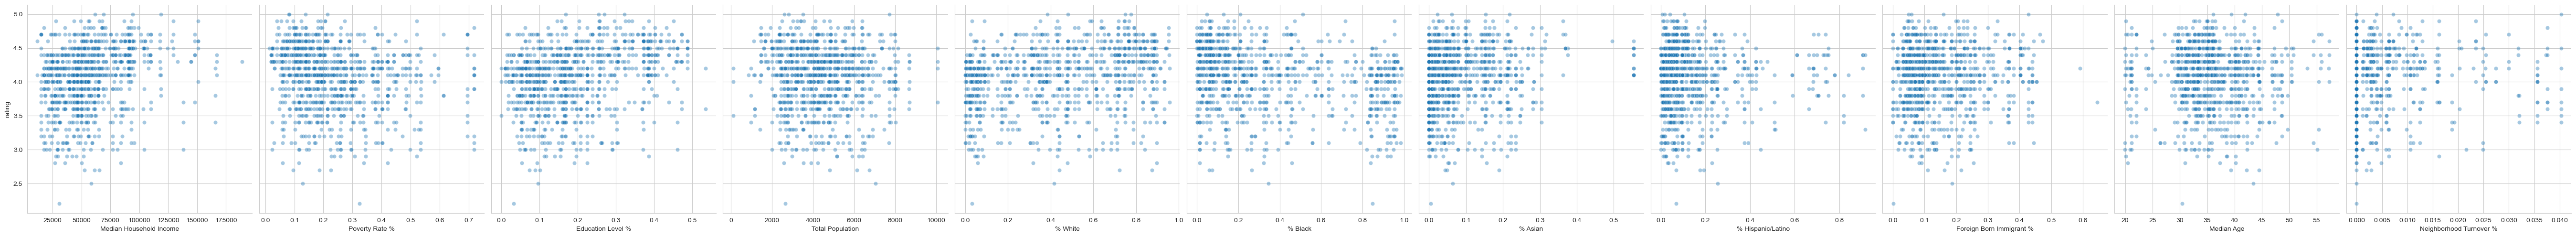

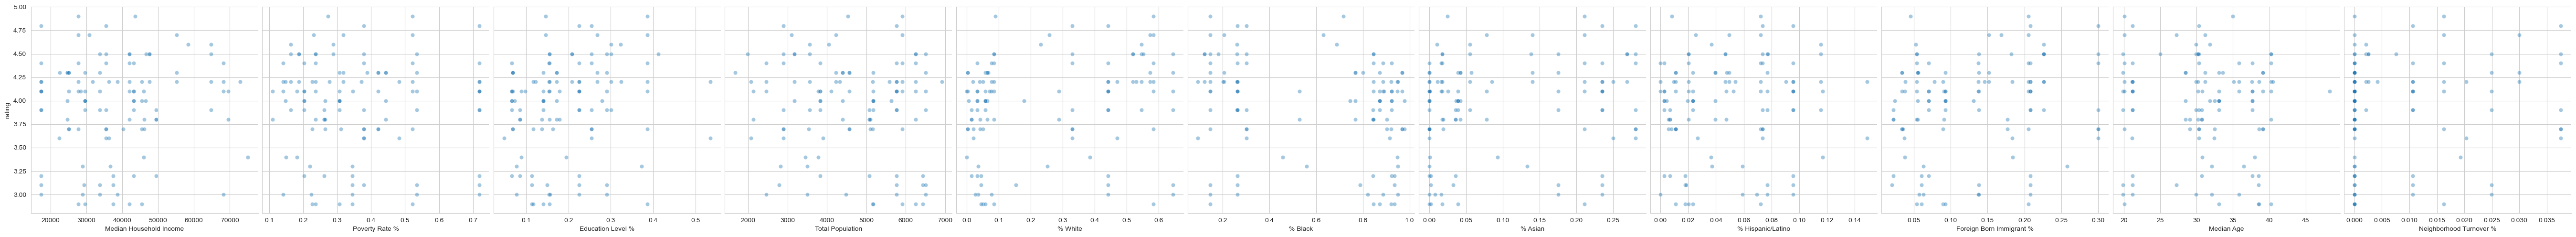

In [3]:
%run "/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/census_and_restaurant_data_withEDA.ipynb"

Recall that the bottom row of graphs corresponds to a borough (West Philly) for which we secured only marginally good estimates via prior k-neighbors regression.

Let us now utilize random forest regression to determine whether and in which manner the addition of census data can sharpen our efforts.

## Random Forest Regression with Census Data

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import root_mean_squared_error

n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle=True, random_state=5501)

In [6]:
#adjoin the features used previously to the new census features
features = ['latitude','longitude', 'photos_count', 'reviews' ] + features.to_list()

features

['latitude',
 'longitude',
 'photos_count',
 'reviews',
 'Median Household Income',
 'Poverty Rate %',
 'Education Level %',
 'Total Population',
 '% White',
 '% Black',
 '% Asian',
 '% Hispanic/Latino',
 'Foreign Born Immigrant %',
 'Median Age',
 'Neighborhood Turnover %']

In [7]:
#prepare a multiindex dataframe keeping track of borough and depth d of random forest
boroughs = np.sort(rd_train.borough.unique())
many_boroughs = np.array([])
many_ds = []

num_depth = 10
for i in range(num_depth): 
    many_boroughs = np.concatenate((boroughs, many_boroughs))
    many_ds = many_ds + len(boroughs)*[i]


In [8]:

rmse = np.zeros((num_depth, n_splits))

rmse_df = pd.DataFrame({"borough": many_boroughs, "d": many_ds})
for d in range(num_depth):
    random_for = RandomForestRegressor(n_estimators=100, max_depth = d+1, random_state=59038, max_features = len(features))
    i = 0
    for train_index, test_index in kfold.split(rd_train, rd_train.borough):
         rd_t_train= rd_train.iloc[train_index]
         rd_t_test = rd_train.iloc[test_index]

         random_for.fit(rd_t_train[features], rd_t_train.rating)
         preds = random_for.predict(rd_t_test[features])
         rmse[d, i] = root_mean_squared_error(rd_t_test.rating, preds)
         
         for bor in rd_t_test.borough.unique():
              rd_t_bor = rd_t_test[rd_t_test.borough == bor]
              bor_preds = random_for.predict(rd_t_bor[features])
              rmse_df.loc[(rmse_df.borough == bor) &(rmse_df.d == d), i] = root_mean_squared_error(rd_t_test[rd_t_test.borough == bor].rating,
                                                                               bor_preds)
         
         i += 1


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least

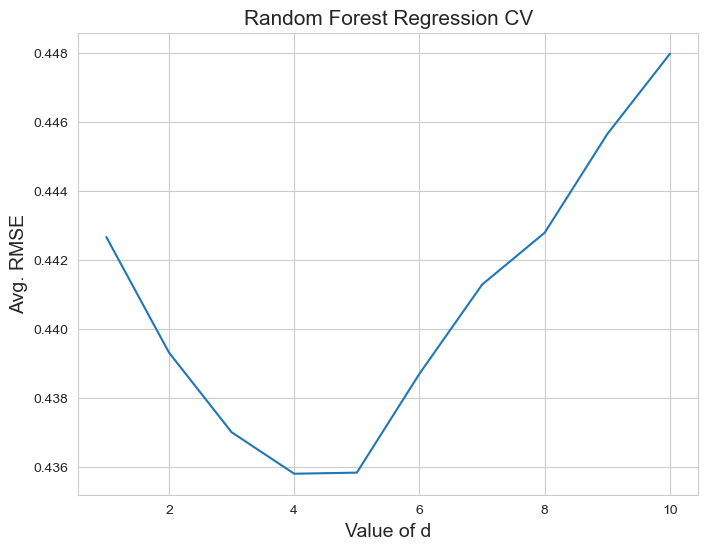

The minimum CV avg. RMSE happens at d = 4 and is equal to  0.436.


In [9]:
plt.figure(figsize=(8,6))

plt.plot(np.arange(1, num_depth+1), np.mean(rmse, axis = 1))
plt.xlabel('Value of d', fontsize = 14)
plt.ylabel('Avg. RMSE', fontsize= 14)
plt.title("Random Forest Regression CV", fontsize = 15)

plt.show()

lowest_d = np.argmin(np.mean(rmse, axis = 1))
min_d = np.arange(1, num_depth + 1)[lowest_d]
print(f"The minimum CV avg. RMSE happens at d = {min_d} and is equal to {np.mean(rmse, axis = 1)[lowest_d]: .3f}.")

Part of our motivation in applying random forest regression is its feature importance scoring. This can aid us in the effective selection of features to use for various clusters of data. Also, random forest regression introduces a certain level of probabilistic reasoning, which may perhaps provide an edge over previous models.

In [10]:
random_for = RandomForestRegressor(n_estimators=100, max_depth = 4, random_state=59038, max_features = len(features))
random_for.fit(rd_train[features], rd_train.rating)

score_df = pd.DataFrame({'feature': features,
                            'importance_score': random_for.feature_importances_})
score_df.sort_values('importance_score', ascending = False)

,feature,importance_score
6,Education Level %,0.310795
3,reviews,0.139023
2,photos_count,0.118791
9,% Black,0.090142
1,longitude,0.076400
0,latitude,0.059033
4,Median Household Income,0.054532
13,Median Age,0.035463
12,Foreign Born Immigrant %,0.025239
10,% Asian,0.020890


In [11]:
score_df.sort_values('importance_score', ascending = False).to_csv("../'Will It Restaurant?'/feature_importances.csv", index = False)

## Gradient Boost Regression with Census Data

We try another model type to see whether boosting offers any improvement in ratings prediction.

In [12]:
rd_train[features]

,latitude,longitude,photos_count,reviews,Median Household Income,Poverty Rate %,Education Level %,Total Population,% White,% Black,% Asian,% Hispanic/Latino,Foreign Born Immigrant %,Median Age,Neighborhood Turnover %
0,39.978995,-75.161721,52.0,193.0,14962.0,0.696408,0.238164,2771.0,0.360881,0.452905,0.066041,0.093107,0.075424,22.0,0.000000
1,39.984704,-75.113389,41.0,410.0,44468.0,0.372692,0.066649,5742.0,0.371125,0.184431,0.024382,0.426855,0.061651,32.0,0.000000
2,40.111658,-74.955353,107.0,251.0,52546.0,0.185559,0.089118,6149.0,0.721418,0.073833,0.048138,0.193202,0.162628,42.2,0.001952
3,39.952899,-75.158244,113.0,193.0,51801.0,0.258769,0.195559,2977.0,0.431643,0.323816,0.142761,0.120927,0.186093,35.2,0.006382
4,39.940403,-75.175860,39.0,114.0,138093.0,0.115480,0.371254,4044.0,0.579871,0.241840,0.124135,0.067013,0.108309,31.1,0.004034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,39.949475,-75.160521,287.0,718.0,90119.0,0.106472,0.402789,1465.0,0.715358,0.104437,0.163823,0.070990,0.101024,29.7,0.000000
955,39.920875,-75.163573,347.0,414.0,68523.0,0.096172,0.144402,5199.0,0.780535,0.041354,0.112714,0.057126,0.214080,37.0,0.000000
956,39.964663,-75.224120,107.0,593.0,29597.0,0.307677,0.140356,5171.0,0.058983,0.871978,0.038871,0.023206,0.092825,33.1,0.000000
957,39.918658,-75.182421,33.0,139.0,84132.0,0.059785,0.190723,3914.0,0.896270,0.011753,0.053654,0.055953,0.083035,40.2,0.000000


In [13]:
rd_train_nomiss = rd_train[rd_train['Median Household Income'].notna()]

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least

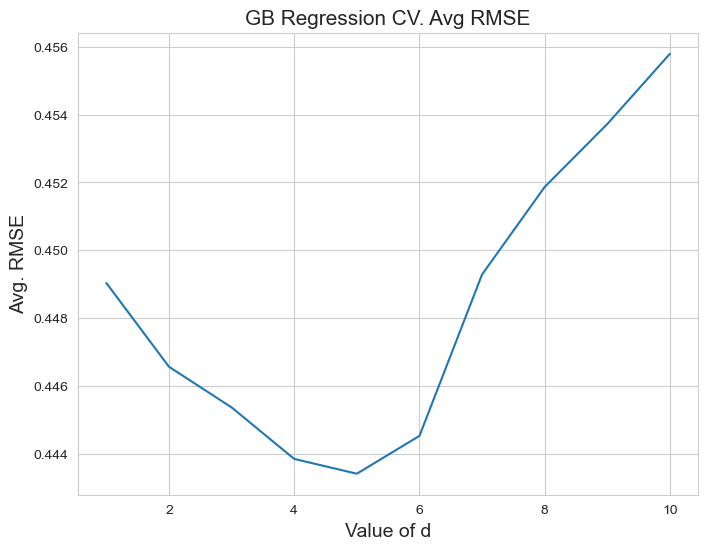

The minimum CV avg. RMSE happens at d = 5 with n = 7.0, and is equal to  0.443.


In [14]:

rmse = np.zeros(num_depth)
ns = np.zeros(num_depth)

rmse_df = pd.DataFrame({"borough": many_boroughs, "d": many_ds})
for d in range(num_depth):
    gb = GradientBoostingRegressor(max_depth=d+1, validation_fraction = 0.1, n_iter_no_change = 6, tol = 0.1)
    
    gb.fit(rd_train_nomiss[features], rd_train_nomiss.rating)
    max_trees = gb.n_estimators_
    rmse_n = np.zeros((max_trees, n_splits))
    for n in range(max_trees):
        i = 0
        for train_index, test_index in kfold.split(rd_train_nomiss, rd_train_nomiss.borough):
            rd_t_train= rd_train_nomiss.iloc[train_index]
            rd_t_test = rd_train_nomiss.iloc[test_index]
         
            gb_2 = GradientBoostingRegressor(n_estimators=n+1, max_depth= d+1, learning_rate= 0.1)
            gb_2.fit(rd_t_train[features], rd_t_train.rating)
            preds = gb_2.predict(rd_t_test[features])
            rmse_n[n, i] = root_mean_squared_error(rd_t_test.rating, preds)
         
            i += 1

    lowest_n = np.argmin(np.mean(rmse_n, axis = 1))
    ns[d] = lowest_n +1
    rmse[d] = np.mean(rmse_n, axis = 1)[lowest_n]



plt.figure(figsize=(8,6))

plt.plot(np.arange(1, num_depth+1), rmse)
plt.xlabel('Value of d', fontsize = 14)
plt.ylabel('Avg. RMSE', fontsize= 14)
plt.title("GB Regression CV. Avg RMSE", fontsize = 15)

plt.show()

lowest_d = np.argmin(rmse)
min_d = np.arange(1, num_depth + 1)[lowest_d]
print(f"The minimum CV avg. RMSE happens at d = {min_d} with n = {ns[lowest_d]}, and is equal to {rmse[lowest_d]: .3f}.")

In [15]:
gb = GradientBoostingRegressor(n_estimators=7, max_depth= 5, learning_rate= 0.1)
gb.fit(rd_train_nomiss[features], rd_train_nomiss.rating)

score_df = pd.DataFrame({'feature': features,
                            'importance_score': gb.feature_importances_})
score_df.sort_values('importance_score', ascending = False)

,feature,importance_score
6,Education Level %,0.265573
3,reviews,0.173583
2,photos_count,0.136910
0,latitude,0.097438
13,Median Age,0.061404
9,% Black,0.057853
1,longitude,0.051439
12,Foreign Born Immigrant %,0.045338
10,% Asian,0.028733
4,Median Household Income,0.025487


## Plots of Residuals and Predictions

In the spirit of boosting even further if necessary, we plot the residuals from our last predictions and compare to the original target plots.

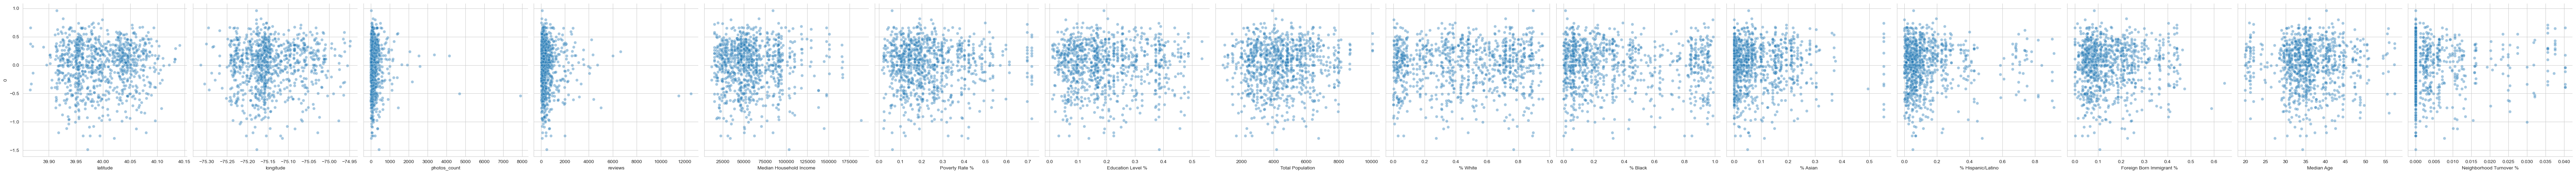

In [16]:
gb = GradientBoostingRegressor(n_estimators=7, max_depth= 5, learning_rate= 0.1)
gb.fit(rd_train_nomiss[features], rd_train_nomiss.rating)
preds = gb.predict(rd_train_nomiss[features])
residuals = rd_train_nomiss.rating.values - preds
#plot residuals against census features
sns.pairplot(pd.concat([rd_train_nomiss, pd.DataFrame(residuals)], axis = 1),
                y_vars = [0],
                x_vars = features,
                height = 5,
                plot_kws={'alpha': 0.4},
                diag_kind = None)

plt.show()

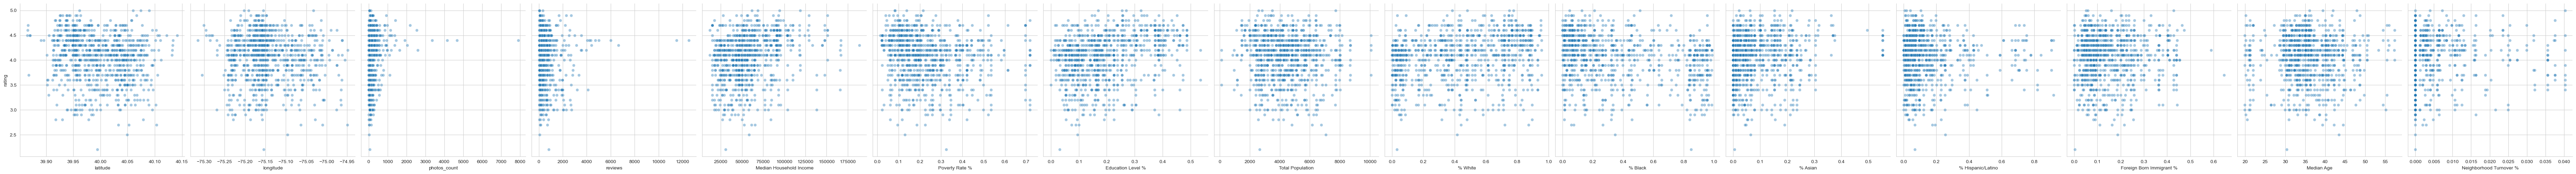

In [17]:
sns.pairplot(rd_train,
                y_vars = 'rating',
                x_vars = features,
                height = 5,
                plot_kws={'alpha': 0.4},
                diag_kind = None)

plt.show()

We can see from the two rows of graphs that the residual plots are more concentrated. We might expect that averaging at this step might be more effective.

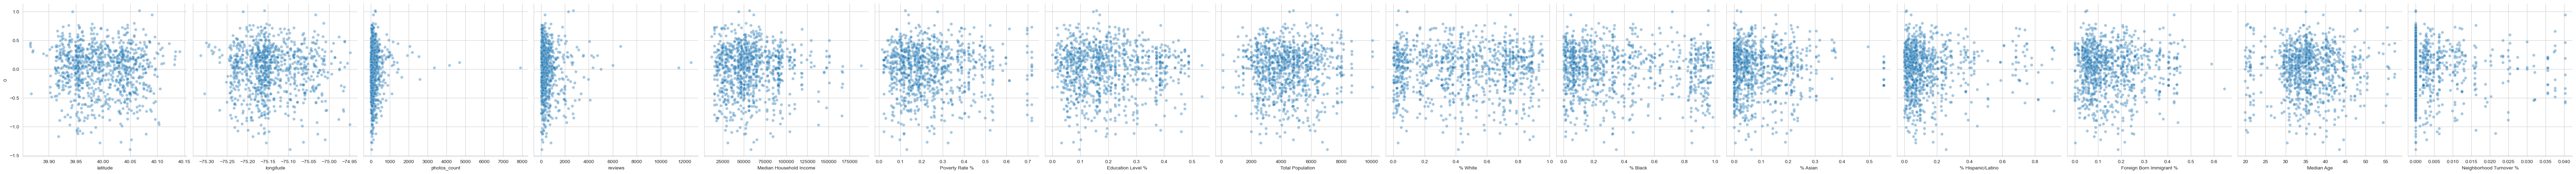

In [18]:
#plot residuals of random forest against census features
preds = random_for.predict(rd_train[features])
residuals = rd_train.rating.values - preds

sns.pairplot(pd.concat([rd_train, pd.DataFrame(residuals)], axis = 1),
                y_vars = 0,
                x_vars = features,
                height = 5,
                plot_kws={'alpha': 0.4},
                diag_kind = None)

plt.show()

We inquire whether feature importances shift for the residuals.

In [19]:
preds = random_for.predict(rd_train[features])
residuals = rd_train.rating.values - preds

random_for = RandomForestRegressor(n_estimators=100, max_depth = 4, random_state=59038, max_features = len(features))
random_for.fit(rd_train[features], residuals)

score_df = pd.DataFrame({'feature': features,
                            'importance_score': random_for.feature_importances_})
score_df.sort_values('importance_score', ascending = False)

,feature,importance_score
3,reviews,0.173086
2,photos_count,0.133293
1,longitude,0.113522
0,latitude,0.079213
13,Median Age,0.076192
4,Median Household Income,0.061546
11,% Hispanic/Latino,0.059753
6,Education Level %,0.056478
12,Foreign Born Immigrant %,0.055734
7,Total Population,0.045698


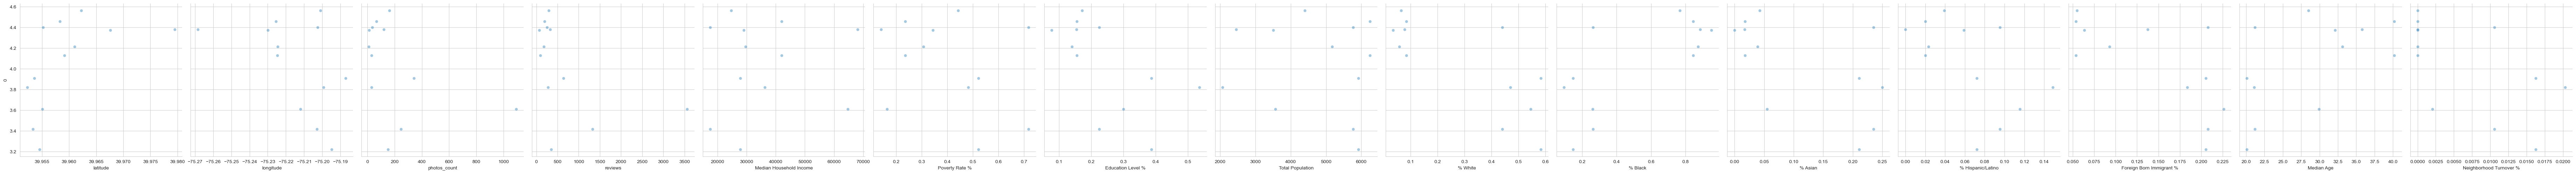

In [20]:
#test residual performance on a 'problematic' borough
west_ph = rd_train[rd_train.borough == 'West Philadelphia']
preds = random_for.predict(west_ph[features])
residuals = west_ph.rating.values- preds
west_ph = pd.concat([west_ph, pd.DataFrame(residuals)], axis = 1)

sns.pairplot(west_ph,
                y_vars = 0,
                x_vars = features,
                height = 5,
                plot_kws={'alpha': 0.4},
                diag_kind = None)

plt.show()

## More Feature Importances and File Uploading

In [21]:
#test feature importances with cuisine identity feature
df = pd.concat([rd_train, pd.get_dummies(rd_train.type)], axis= 1)

#we add 'site' and 'booking_appointment_link' in just for curiosity along with the cuisine types as dummy variables
features = features + list(df.columns[[1] +[29] + list(range(52, 143)) ])
random_forc = RandomForestRegressor(n_estimators=100, max_depth = 4, random_state=59038, max_features = len(features))
random_forc.fit(df[features], df.rating)

score_df = pd.DataFrame({'feature': features,
                            'importance_score': random_forc.feature_importances_})
score_df.sort_values('importance_score', ascending = False, inplace = True)

In [22]:

preds = random_forc.predict(df[features])

rmse_cuis = root_mean_squared_error(df.rating, preds)
print(f"The rmse for random forest regression with 'site' and 'booking_appointment_link' features plus cuisine types is {rmse_cuis: .3f}.")

The rmse for random forest regression with 'site' and 'booking_appointment_link' features plus cuisine types is  0.364.


This is better than the rmse returned above; however, it is not cross-validated. We will draw insight from this in the next notebook.

In [27]:

score_df.to_csv("/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/feature_importances_w_cuisine_types.csv", index = False)
score_df.head(10)

,feature,importance_score
54,Fast food restaurant,0.276157
6,Education Level %,0.143648
83,Pizza delivery,0.118149
2,photos_count,0.106605
9,% Black,0.075303
36,Chicken restaurant,0.040847
4,Median Household Income,0.035903
3,reviews,0.035062
1,longitude,0.024645
38,Chinese restaurant,0.021764


It is interesting to note from this line of inquiry that fast food and pizza delivery restaurants skew the data (of restaurant ratings). For, other than Chicken restaurants and Chinese restaurants, these are the only cuisine types noted as having an appreciable effect. As well, note that 'site' and 'booking_appointment_link' are not impactful statistically.

In preparation for the next notebook, we write to file the features that we have determined to hold sufficient importance. We shall also record the corresponding restaurants dataframe that we are analyzing. 

In [24]:
features = [features[i] for i in range(15) if i not in [5,7,8,10,14]]
with open("../'Will It Restaurant?'/final_features.csv", 'w+') as file:
    file.write('features\n')
    for item in features:
        file.write(str(item) + "\n")

In [25]:
rd_train.to_csv("../'Will It Restaurant?'/final_level1_train_data.csv", index = False)

In [26]:
features

['latitude',
 'longitude',
 'photos_count',
 'reviews',
 'Median Household Income',
 'Education Level %',
 '% Black',
 '% Hispanic/Latino',
 'Foreign Born Immigrant %',
 'Median Age']